## K2-24 Fitting & Nested Sampling

Using the K2-24 (EPIC-203771098) dataset, we demonstrate how to use the radvel API to sample the posterior distribution and calculate the evidence with Nested Sampling.
Most of the code here is copied from the K2-24 MCMC tutorial, but adapted for nested sampling.
Instead of first fitting circular orbits and then eccentric orbits, we will compare models with one and two planets.

### Single-planet model

Perform some preliminary imports:

In [1]:
# TODO: Update names for single vs two instead of circular vs ecc
import os

import matplotlib
import numpy as np
import pylab as pl
import pandas as pd
from scipy import optimize

import corner

import radvel
import radvel.likelihood
from radvel.plot import orbit_plots, mcmc_plots
import matplotlib.pyplot as plt

matplotlib.rcParams['font.size'] = 14

Define a function that we will use to initialize the ``radvel.Parameters``, ``radvel.RVModel``, ``radvel.RVLikelihood``, and ``Radvel.Posterior`` objects.
The number of planets is an argument so we can re-use the function to generate the model later.

In [2]:
def initialize_model(num_planets):
    time_base = 2420
    params = radvel.Parameters(num_planets,basis='per tc secosw sesinw logk') # number of planets = 2
    params['per1'] = radvel.Parameter(value=20.885258)
    params['tc1'] = radvel.Parameter(value=2072.79438)
    params['secosw1'] = radvel.Parameter(value=0.01)
    params['sesinw1'] = radvel.Parameter(value=0.01)
    params['logk1'] = radvel.Parameter(value=1.1)
    if num_planets == 2:
        params['per2'] = radvel.Parameter(value=42.363011)
        params['tc2'] = radvel.Parameter(value=2082.62516)
        params['secosw2'] = radvel.Parameter(value=0.01)
        params['sesinw2'] = radvel.Parameter(value=0.01)
        params['logk2'] = radvel.Parameter(value=1.1)
    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = radvel.Parameter(value=-0.02)
    mod.params['curv'] = radvel.Parameter(value=0.01)

    like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)
    like.params['gamma'] = radvel.Parameter(value=0.1, vary=False, linear=True)
    like.params['jit'] = radvel.Parameter(value=1.0)
    like.params['secosw1'].vary = False
    like.params['sesinw1'].vary = False
    like.params['per1'].vary = False
    like.params['tc1'].vary = False
    if num_planets == 2:
        like.params['secosw2'].vary = False
        like.params['sesinw2'].vary = False
        like.params['per2'].vary = False
        like.params['tc2'].vary = False

    post = radvel.posterior.Posterior(like)
    post.priors += [radvel.prior.Gaussian('jit', np.log(3), 0.5)]
    post.priors += [radvel.prior.Gaussian('logk1', np.log(5), 10)]
    post.priors += [radvel.prior.Gaussian('dvdt', 0, 1.0)]
    post.priors += [radvel.prior.Gaussian('curv', 0, 1e-1)]
    if num_planets == 2:
        post.priors += [radvel.prior.Gaussian('logk2', np.log(5), 10)]

    return post

Define a simple plotting function to display the data, model, and residuals

In [3]:
def plot_results(like):
    fig = pl.figure(figsize=(12,4))
    fig = pl.gcf()
    fig.set_tight_layout(True)
    pl.errorbar(
        like.x, like.model(t)+like.residuals(), 
        yerr=like.yerr, fmt='o'
        )
    pl.plot(ti, like.model(ti))
    pl.xlabel('Time')
    pl.ylabel('RV')
    pl.draw()

Load up the K2-24 data. In this example the RV data and parameter starting guesses are stored in a csv file.

In [4]:
path = os.path.join(radvel.DATADIR,'epic203771098.csv')
rv = pd.read_csv(path)

t = np.array(rv.t)
vel = np.array(rv.vel)
errvel = rv.errvel
ti = np.linspace(rv.t.iloc[0]-5,rv.t.iloc[-1]+5,100)

In [5]:
post = initialize_model(1)
print(post)

parameter                     value      vary
per1                        20.8853      False
tc1                         2072.79      False
secosw1                        0.01      False
sesinw1                        0.01      False
logk1                           1.1       True
dvdt                          -0.02       True
curv                           0.01       True
gamma                           0.1      False
jit                               1       True
tp1                         2070.18           
e1                           0.0002           
w1                         0.785398           
k1                          3.00417           

Priors
------
Gaussian prior on jit, mu=1.0986122886681096, sigma=0.5
Gaussian prior on logk1, mu=1.6094379124341003, sigma=10
Gaussian prior on dvdt, mu=0, sigma=1.0
Gaussian prior on curv, mu=0, sigma=0.1



Plot the initial model

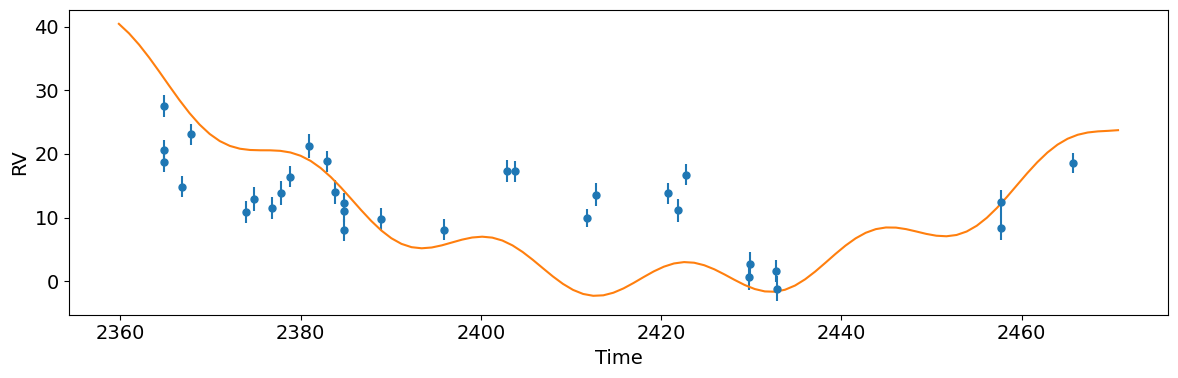

In [6]:
plot_results(post.likelihood)
plt.show()

Well that solution doesn't look very good. Now lets try to optimize the parameters set to vary by maximizing the likelihood and printing the updated posterior object.

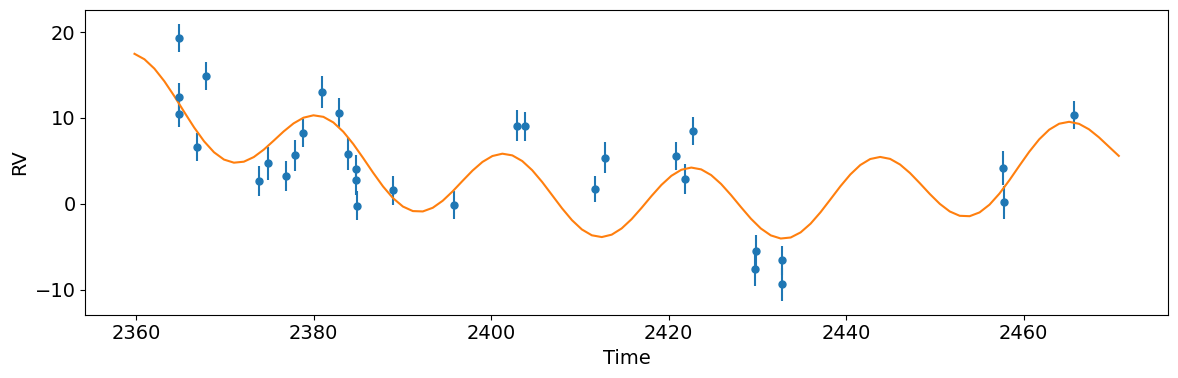

parameter                     value      vary
per1                        20.8853      False
tc1                         2072.79      False
secosw1                        0.01      False
sesinw1                        0.01      False
logk1                       1.45048       True
dvdt                     -0.0258229       True
curv                     0.00321625       True
gamma                      -5.48058      False
jit                         3.72765       True
tp1                         2070.18           
e1                           0.0002           
w1                         0.785398           
k1                          4.26516           

Priors
------
Gaussian prior on jit, mu=1.0986122886681096, sigma=0.5
Gaussian prior on logk1, mu=1.6094379124341003, sigma=10
Gaussian prior on dvdt, mu=0, sigma=1.0
Gaussian prior on curv, mu=0, sigma=0.1



In [7]:
res  = optimize.minimize(
    post.likelihood.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Nelder-Mead',           # Powell also works
    )
bic_circular = post.likelihood.bic()
plot_results(post.likelihood)             # plot best fit model
plt.show()
print(post)

That looks much better!

Now lets use Nested Sampling to estimate the parameter uncertainties and bayesian evidence!

#### Prior check

Before running the inference, it is always a good idea to check the prior to make sure it produces the samples we expect.
We can easily do this by generating uniform samples and transforming them to prior space using ``radvel.Posterio.prior_transform()``.

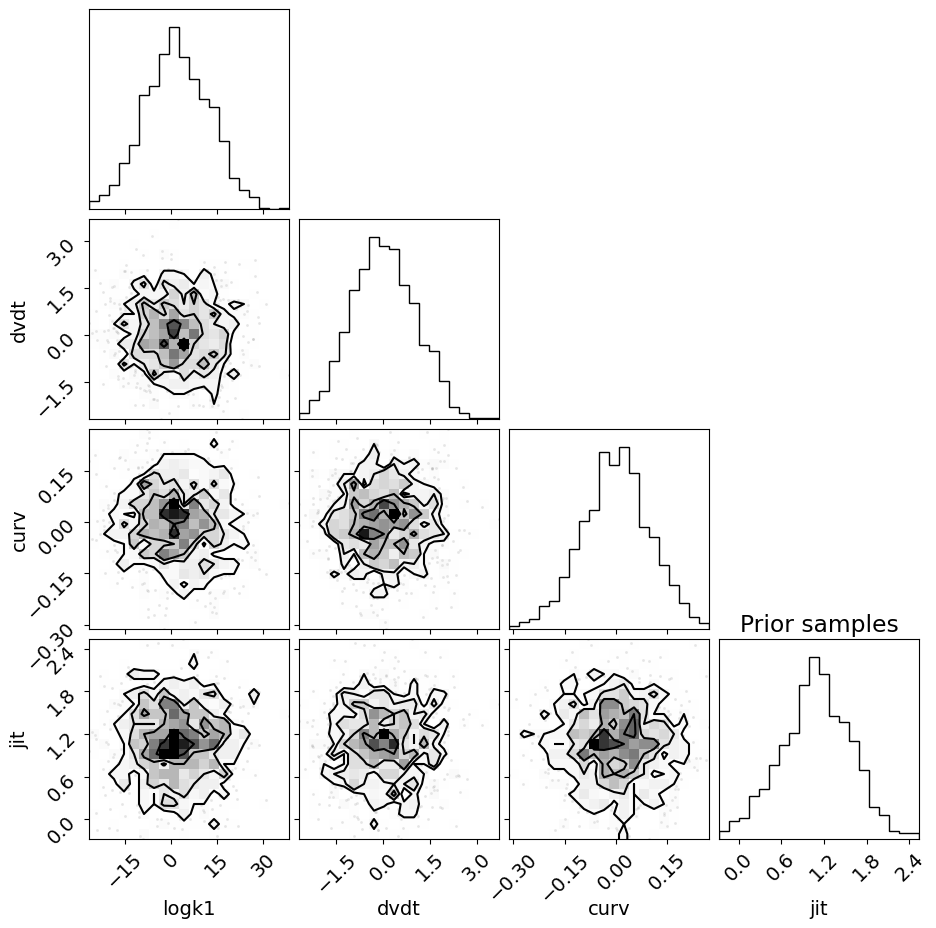

In [8]:
u = np.random.random(size=(len(post.priors), 1000))
prior_samples = post.prior_transform(u)

fig = corner.corner(prior_samples.T, labels=post.name_vary_params())
plt.title("Prior samples")
plt.show()

#### Sampling

We can then run nested sampling with a single line.
RadVel calls [Ultranest](https://johannesbuchner.github.io/UltraNest/index.html) under the hood.
Keyword arguments can be passed to ``ReactiveNestedSampler`` and ``ReactiveNestedSampler.run()`` via
the ``sampler_kwargs`` and ``run_kwargs`` dictionaries, respectively.

The RadVel function returns the ``ReactiveNestedSampler`` object. The sampling results can be accessed through
``ReactiveNestedSampler.results`` the full sampling sequence can be accessed through ``ReactiveNestedSampler.run_sequence``.


In [9]:
sampler_single = radvel.nested_sampling(post)

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-9e+01  4 [-90.3751..-90.3749]*| it/evals=9840/106183 eff=9.3021% N=400       0  00 
[ultranest] Likelihood function evaluations: 106286
[ultranest]   logZ = -110.2 +- 0.1386
[ultranest] Effective samples strategy satisfied (ESS = 2909.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.20 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.


#### Plotting

Ultranest also has quite a few plotting utility functions to visualize the sampling process.

Let us first generate the so-called `runplot` and `traceplot`.

In [10]:
from ultranest.plot import cornerplot, runplot, traceplot

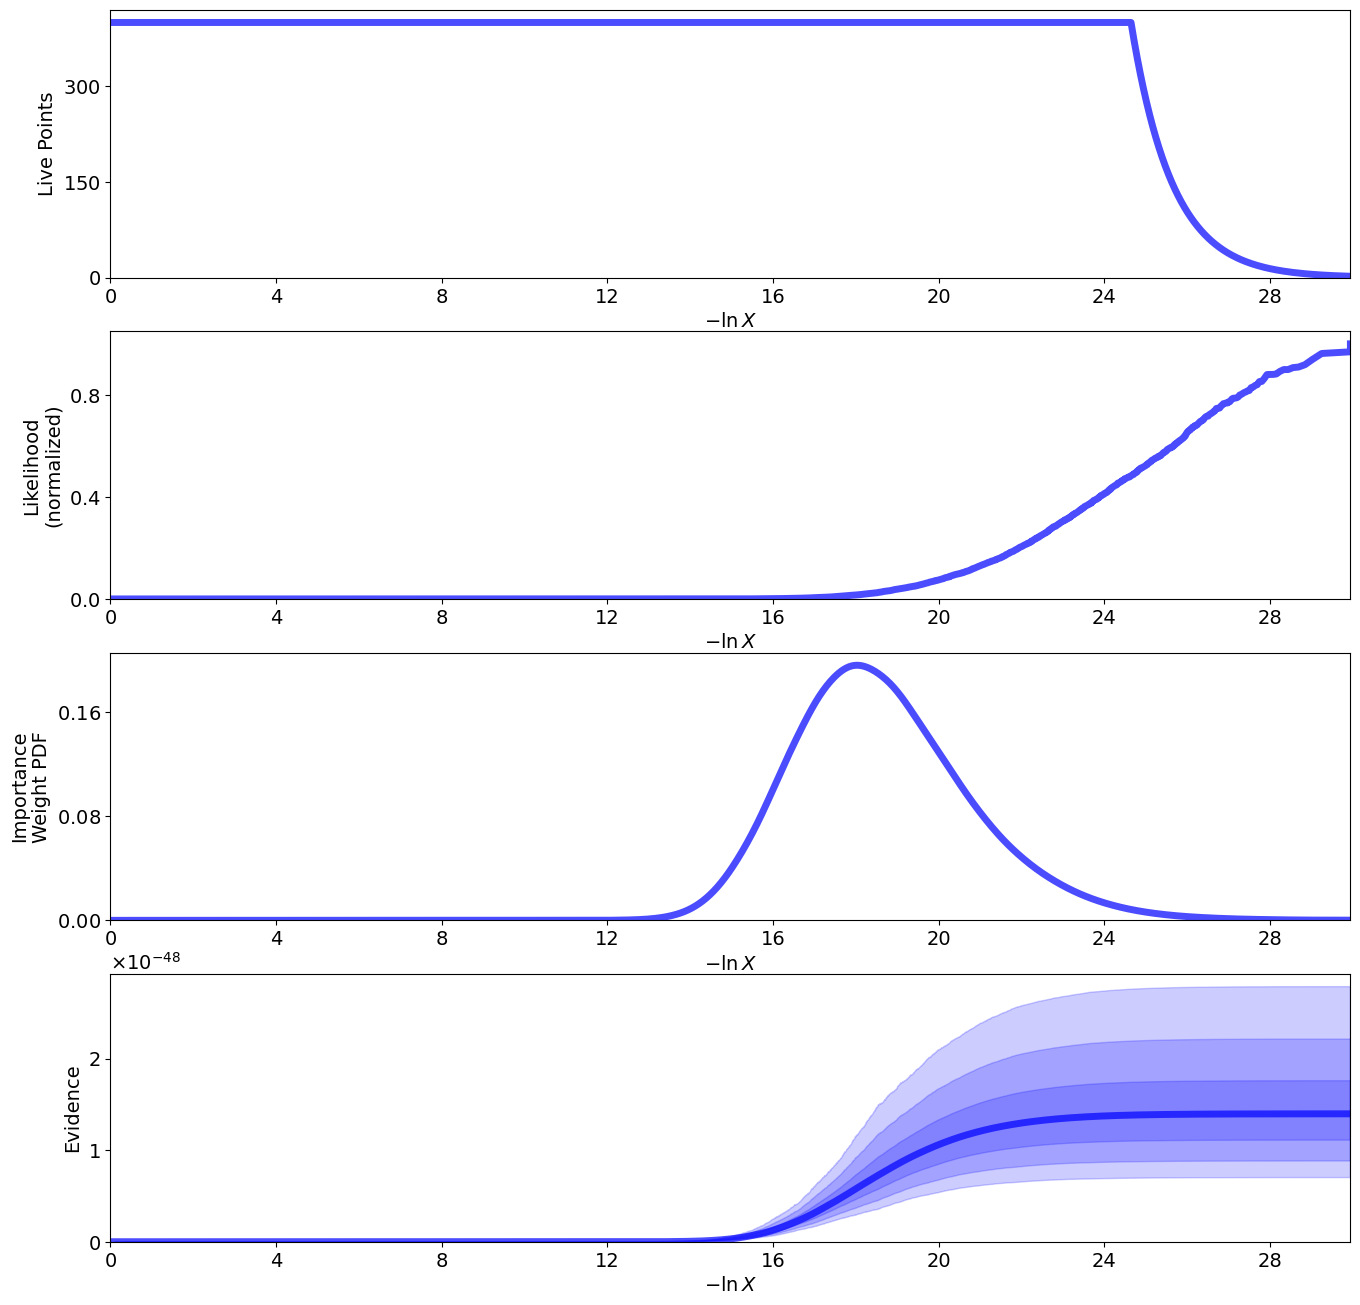

In [11]:
runplot(sampler_single.run_sequence)
plt.show()

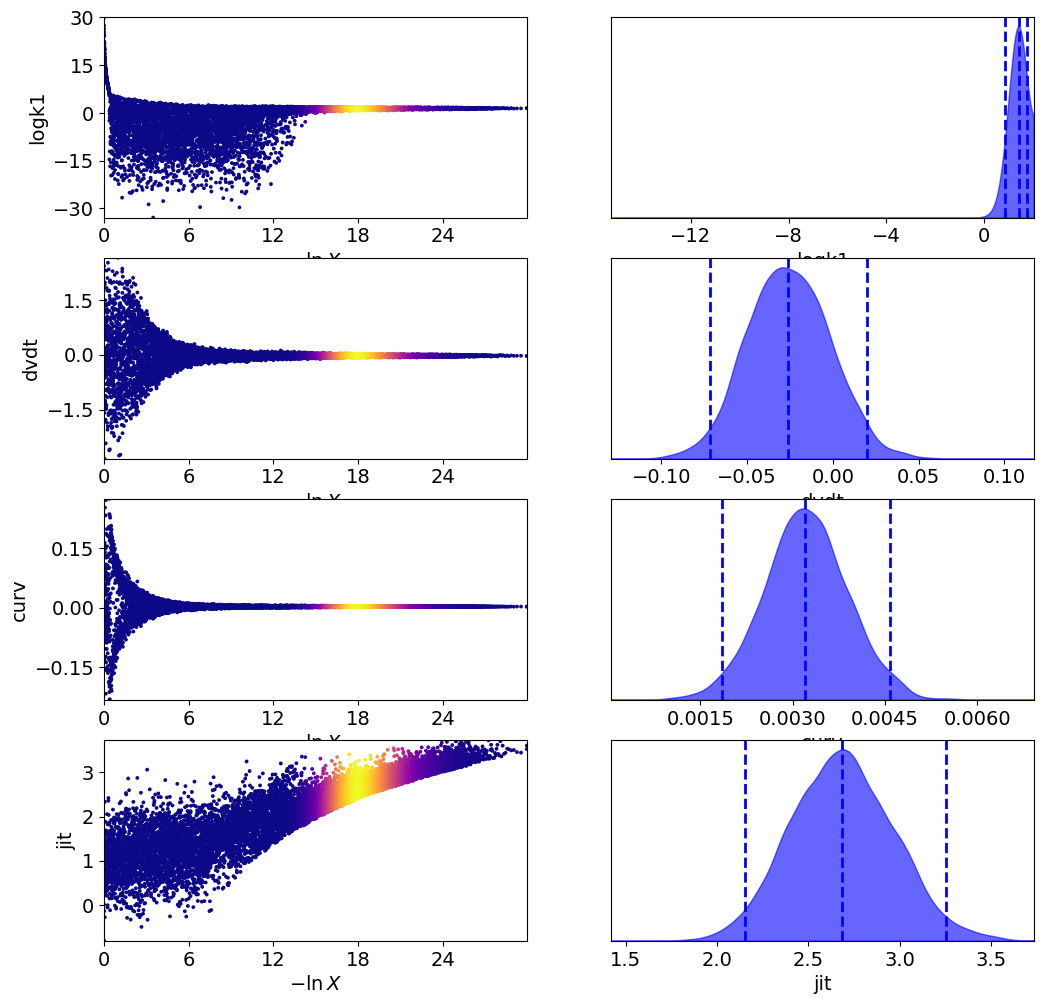

In [12]:
traceplot(sampler_single.run_sequence, labels=post.name_vary_params())
plt.show()

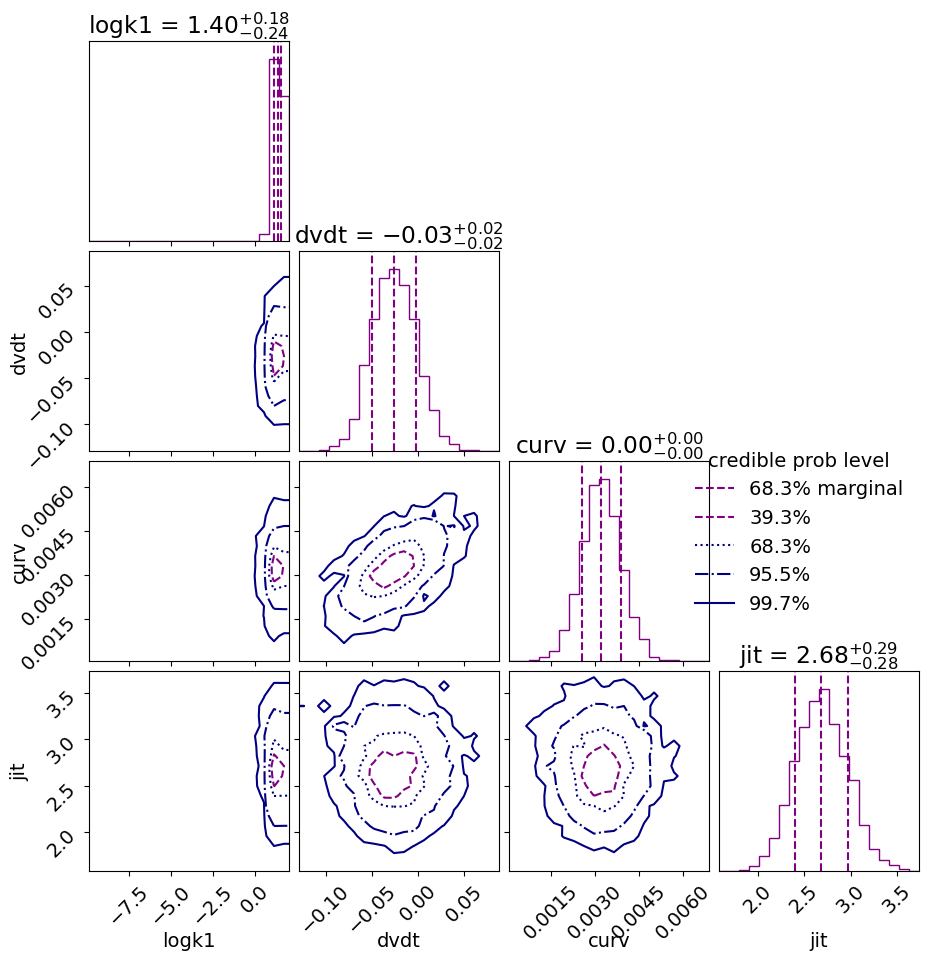

In [13]:
cornerplot(sampler_single.results)
plt.show()

#### Bayesian Evidence

The log-evidence is in the nested sampling results under the `logz` key.
Let's extract it so it can be used for model comparison later.

In [14]:
logz_single = sampler_single.results["logz"]
print(f"The log-evidence for the single planet model is {logz_single:.2f}")

The log-evidence for the single planet model is -110.19


### Two-planet model

We will now repeat all of the above steps using a two-planet model.

In [15]:
post = initialize_model(2)

In [16]:
post.name_vary_params()

['logk1', 'logk2', 'dvdt', 'curv', 'jit']

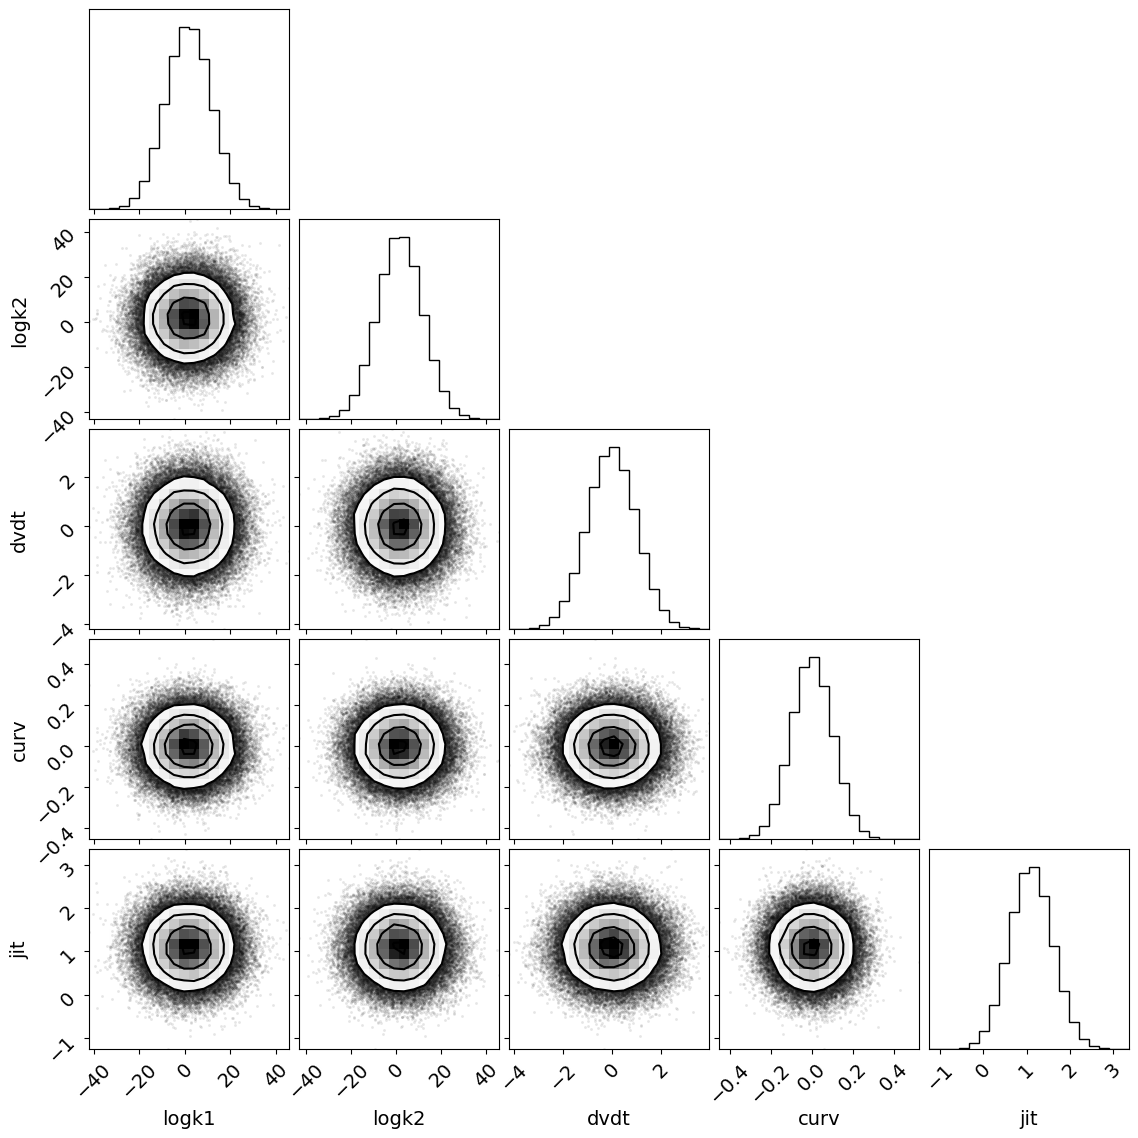

In [17]:
u = np.random.random(size=(len(post.name_vary_params()), 100_000))
prior_samples = post.prior_transform(u)

corner.corner(prior_samples.T, labels=post.name_vary_params())
plt.show()

Optimize the parameters by maximizing the likelihood and plot the result

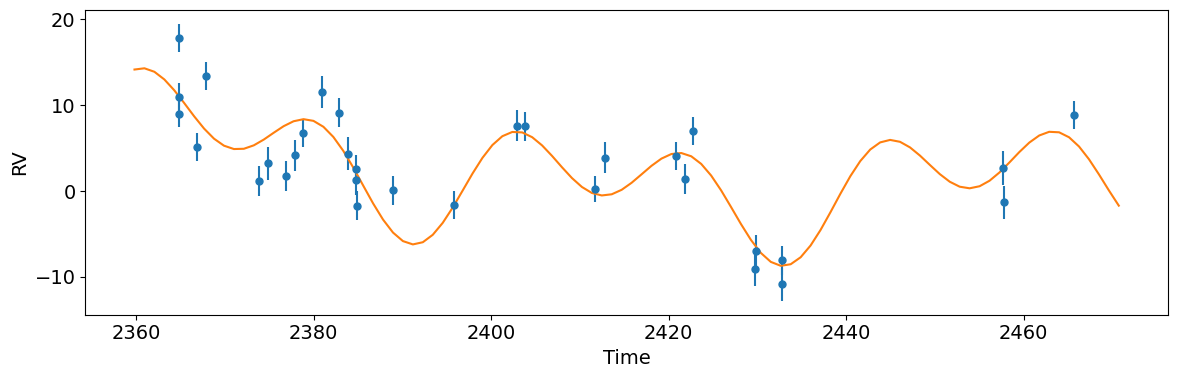

parameter                     value      vary
per1                        20.8853      False
tc1                         2072.79      False
secosw1                        0.01      False
sesinw1                        0.01      False
logk1                       1.54962       True
per2                         42.363      False
tc2                         2082.63      False
secosw2                        0.01      False
sesinw2                        0.01      False
logk2                       1.37557       True
dvdt                     -0.0296175       True
curv                     0.00182308       True
gamma                      -4.00009      False
jit                         2.09057       True
tp1                         2070.18           
e1                           0.0002           
w1                         0.785398           
k1                          4.70968           
tp2                         2077.33           
e2                           0.0002           
w2            

In [18]:
res  = optimize.minimize(
    post.neglogprob_array, 
    post.get_vary_params(), 
    method='Powell',)
bic_ecc = post.likelihood.bic()
plot_results(post.likelihood)
plt.show()
print(post)

Plot the final solution

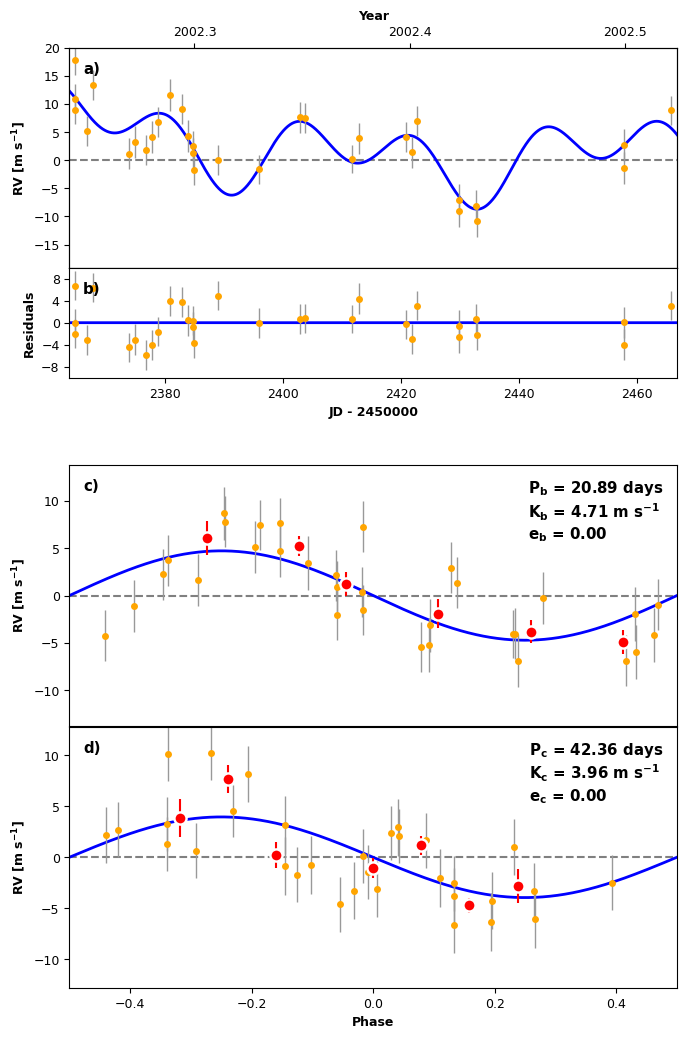

In [19]:
RVPlot = orbit_plots.MultipanelPlot(post, legend=False)
RVPlot.plot_multipanel()
plt.show()

In [20]:
sampler_ecc = radvel.nested_sampling(post)

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8e+01  6 [-82.8608..-82.8607]*| it/evals=10019/299062 eff=3.3546% N=400  400 0 0   
[ultranest] Likelihood function evaluations: 299153
[ultranest]   logZ = -103.2 +- 0.1664
[ultranest] Effective samples strategy satisfied (ESS = 2634.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.17, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.17 tail:0.01 total:0.17 required:<0.50
[ultranest] done iterating.


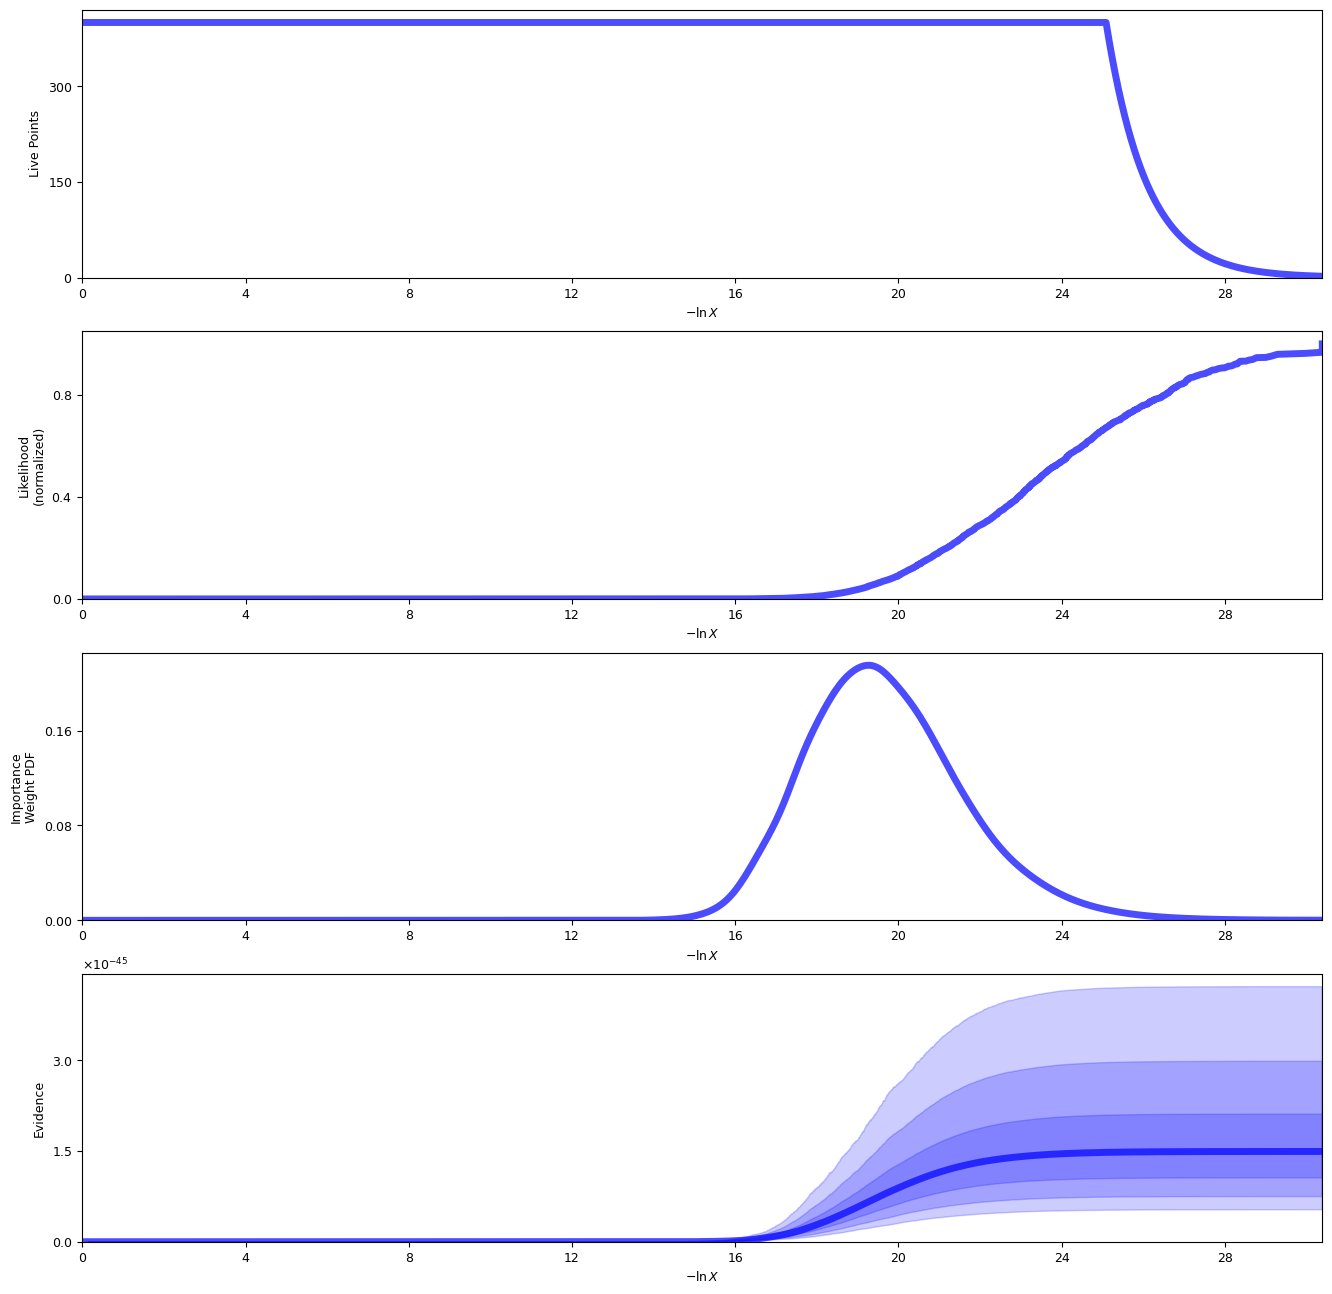

In [21]:
runplot(sampler_ecc.run_sequence)
plt.show()

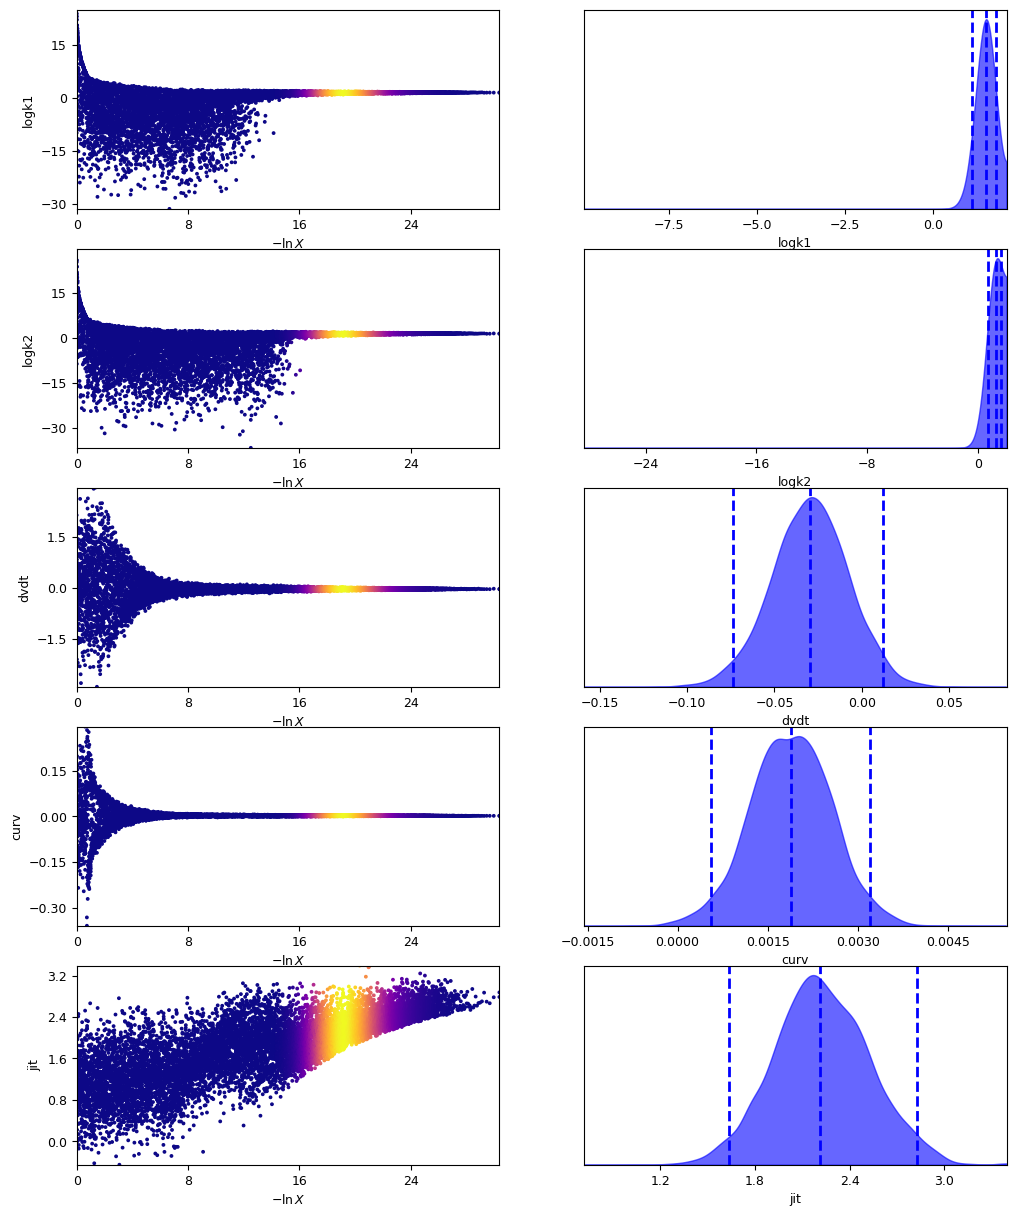

In [22]:
traceplot(sampler_ecc.run_sequence, labels=post.name_vary_params())
plt.show()

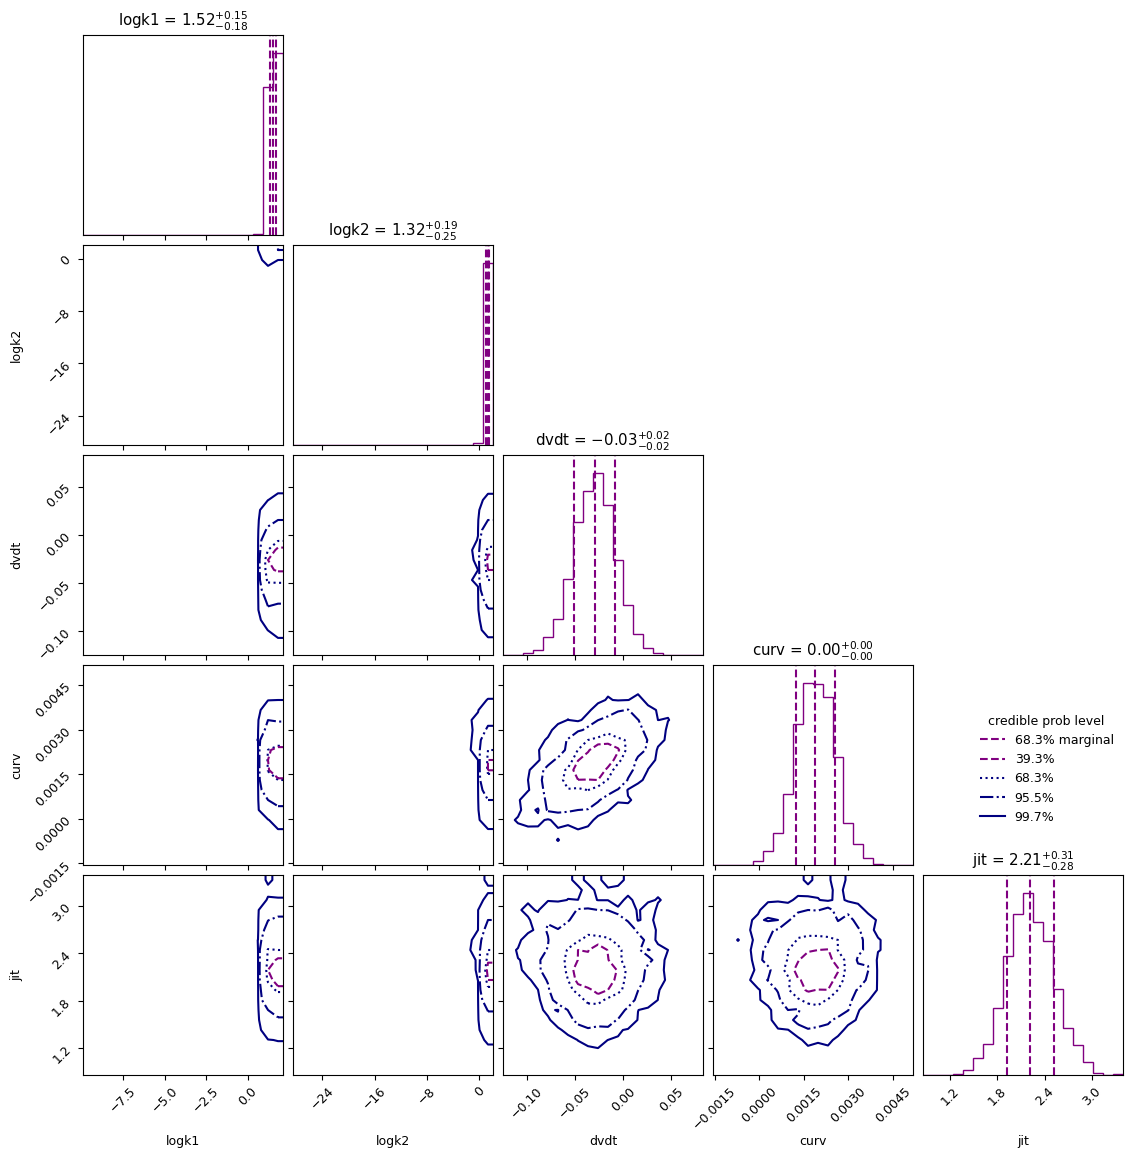

In [23]:
cornerplot(sampler_ecc.results, show_titles=True)
plt.show()

In [26]:
df = radvel.mcmc(post,nwalkers=50,nrun=1000,savename='rawchains.h5')

20000/400000 (5.0%) steps complete; Running 21430.00 steps/s; Mean acceptance rate = 57.7%; Min Auto Factor =  23; Max Auto Relative-Change =   inf; Min Tz = 4951.6; Max G-R = 1.006
Discarding burn-in now that the chains are marginally well-mixed

280000/400000 (70.0%) steps complete; Running 20251.44 steps/s; Mean acceptance rate = 55.1%; Min Auto Factor =  97; Max Auto Relative-Change = 0.0168; Min Tz = 17849.2; Max G-R = 1.002
Chains are well-mixed after 280000 steps! MCMC completed in 14.7 seconds




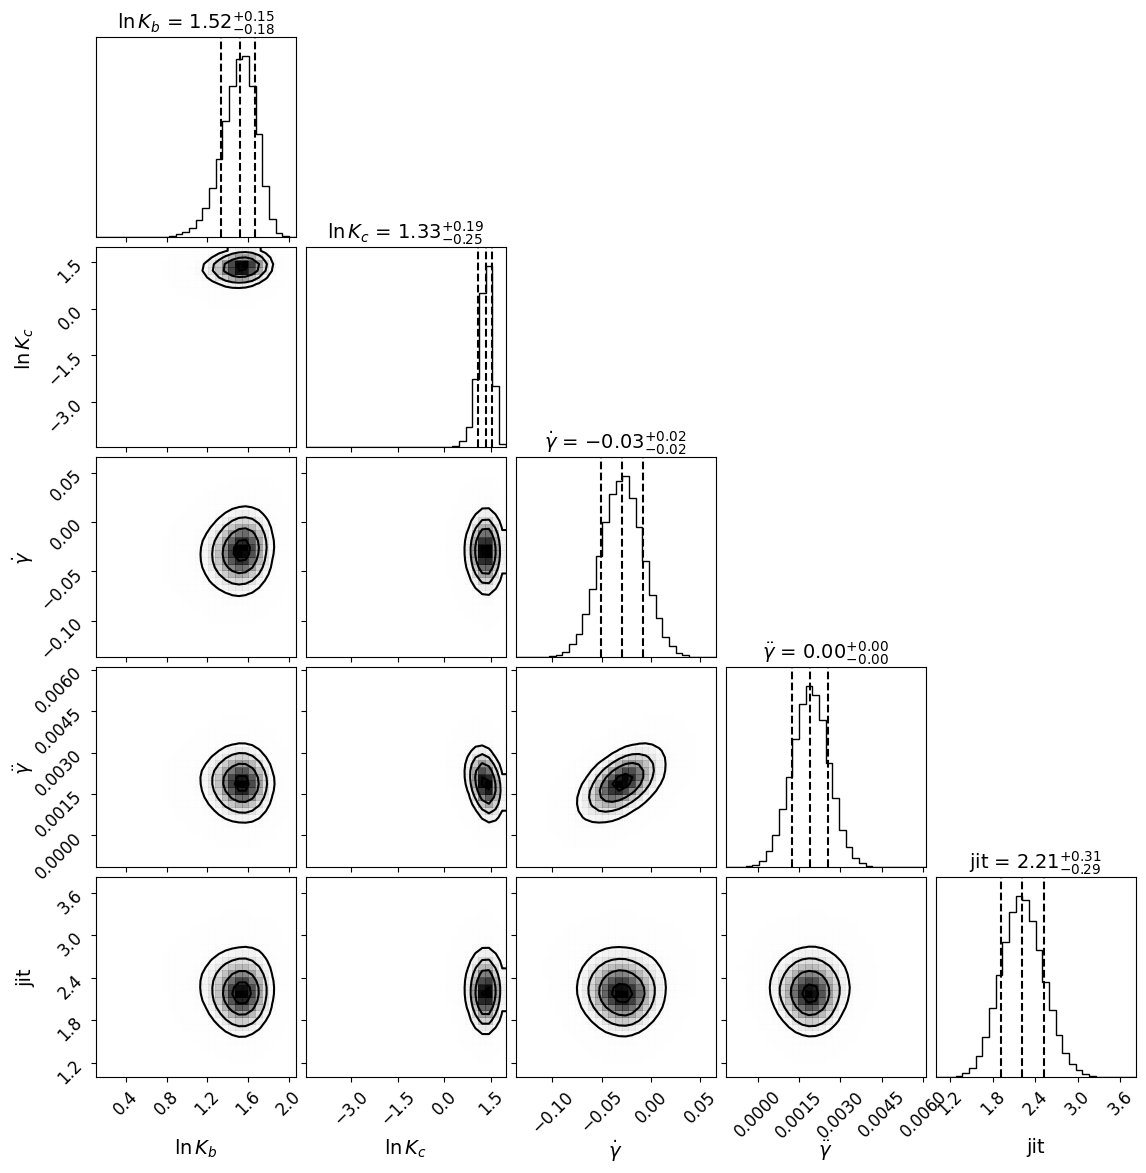

In [27]:
Corner = mcmc_plots.CornerPlot(post, df)
Corner.plot()
plt.show()

In [28]:
logz_ecc = sampler_ecc.results["logz"]
logz_circular = sampler_single.results["logz"]

In [29]:
# Highest evidence is better
logz_ecc - logz_circular

6.975194272280945

In [30]:
bic_circular - bic_ecc

8.354218500442443